# The GAN as explained by "Deep Learning with Python"

In [1]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt
import glob
import json

In [2]:
latent_dim = 18
height = 18
width = 18
channels = 2

image_width = 728
image_height = 728

In [3]:
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.get_visible_devices('GPU')

2.2.0-rc3


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Generator

In [4]:
generator_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(128 * 9 * 9)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((9, 9, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18)]              0         
_________________________________________________________________
dense (Dense)                (None, 10368)             196992    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 10368)             0         
_________________________________________________________________
reshape (Reshape)            (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 9, 9, 256)         819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 9, 9, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 18, 18, 256)       104883

# Discriminator

In [5]:
height=18
width=18
channels=2

discriminator_input = layers.Input(shape=(height, width, channels))

x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
#x = layers.Conv2D(128, 4, strides=2)(x)
#x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

x = layers.Dropout(0.4)(x)

x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 18, 18, 2)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       2432      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 2, 2, 128)         262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 2, 2, 128)         0   

# Discriminator Optimizer

In [6]:
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.00008,
                                                  clipvalue=1.0,
                                                  decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer,
                      loss='binary_crossentropy')

# GAN

In [7]:
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
x = generator(gan_input)
x = discriminator(x)
gan = keras.models.Model(gan_input, x)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0008,
                                         clipvalue=1.0,
                                         decay=1e-8)

gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

# Prepare Training

In [8]:
base_path = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2/train'

files = glob.glob(base_path+'/*.json')

file_length =len(files)

x_position = np.full((file_length, height, width), 0)
y_position = np.full((file_length, height, width), 0)

for file_id, file in enumerate(files):
    with open(file) as json_file:
        data = json.load(json_file)
        
        for key, value in data.items():
            key = int(key)
        
            y = key // height 
            x = key % width

            x_position[file_id][y][x] = value[0]
            y_position[file_id][y][x] = value[1]
            
np.save('x_pos', x_position)
np.save('y_pos', y_position)

In [9]:
x_position = np.load('x_pos.npy')
y_position = np.load('y_pos.npy')

x_position = x_position / image_width
y_position = y_position / image_height

a = x_position

# Zero padding
#x_position = np.pad(x_position,[(0,0),(1,1),(1,1)],constant_values=0)
#y_position = np.pad(y_position,[(0,0),(1,1),(1,1)],constant_values=0)

x_position = x_position[:,:,:,np.newaxis]
y_position = y_position[:,:,:,np.newaxis]

x_train = np.concatenate((x_position, y_position), axis=3)

In [10]:
x_train.shape

(160, 18, 18, 2)

# GAN Training

In [11]:
iterations = 30
batch_size = 20
save_dir = 'gan_lasten2'

start = 0
for step in range(iterations):
    # Get random 'fake' images
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim)) # sample with mean=0 and std=1.0
    
    generated_images = generator.predict(random_latent_vectors)
    
    # Get 'real' images, merge them with 'fake' and create labels
    stop = start + batch_size
    real_images = x_train[start:stop]
    combined_images = np.concatenate([generated_images, real_images])
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    
    labels += 0.05 * np.random.random(labels.shape) # important to introduce some randomness
    
    # Train the discriminator on 'real' and 'fake' images
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # Get random images from generator but treat them as 'real' now
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    misleading_targets = np.zeros((batch_size, 1))
    
    # Train the generator's weights
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    # Finalize loop
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
        
    if step % 2 == 0:
        gan.save_weights('gan.h5')
        print('discriminator loss:', d_loss)
        print('adversarial loss:', a_loss)
        
        gen = generated_images[0,:,:,0][:,:,np.newaxis]
        real = real_images[0,:,:,0][:,:,np.newaxis]
        
        img = image.array_to_img(gen * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated' + str(step) + '.png'))
        
        img = image.array_to_img(real * 255., scale=False)
        img.save(os.path.join(save_dir, 'real' + str(step) + '.png'))

discriminator loss: 0.7112607359886169
adversarial loss: 0.6937574148178101
discriminator loss: 0.687309980392456
adversarial loss: 0.7942737340927124
discriminator loss: 0.6342492699623108
adversarial loss: 0.9576197862625122
discriminator loss: 0.6975255012512207
adversarial loss: 0.707342267036438
discriminator loss: 0.6470522880554199
adversarial loss: 0.8273881673812866
discriminator loss: 0.6123018264770508
adversarial loss: 0.9334529638290405
discriminator loss: 0.5875279307365417
adversarial loss: 1.1727354526519775
discriminator loss: 0.5589766502380371
adversarial loss: 1.3346006870269775
discriminator loss: 0.5289129018783569
adversarial loss: 1.3716436624526978
discriminator loss: 0.5209511518478394
adversarial loss: 1.3833038806915283
discriminator loss: 0.5011485815048218
adversarial loss: 1.4920706748962402
discriminator loss: 0.4682406783103943
adversarial loss: 1.6508150100708008
discriminator loss: 0.4559561312198639
adversarial loss: 1.557044267654419
discriminator l

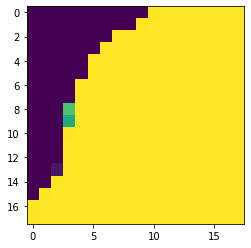

In [32]:
random_latent_vectors = np.random.normal(size=(batch_size, latent_dim)) # sample with mean=0 and std=1.0
    
generated_images = generator.predict(random_latent_vectors)
generated_images *= 255

for i in range(1):
    img = generated_images[i,:,:,0]
    img = img[:,:,np.newaxis]
    img = keras.preprocessing.image.array_to_img(img)
    plt.imshow(img)